# Forecasting stock price with combined sentiment analysis and deep learning

The stock market is highly influenced by emerging news in addition to the price data and technical indicators. Thus, this pipline combines news sentiment analysis with a deep learning model to better forecast stock prices, and then send the forecasts conituously to your phone via Telegram.

Here's a basic outline of the workflow:
- 1.) Import all dependencies
- 2.) Fetch all numeric and news data
- 3.) Ensemble Roberta, VaderSentiment, and TextBlob sentiment analyses of the news
- 4.) Combine the sentiment analyses with the numeric stock data
- 5.) Train a GRU model on this combined data
- 6.) Forecast stock prices via the GRU model & Monte Carlo simulations for any given stock(s) for any given number of day(s)
- 7.) Push the news and forecasts to Telegram 
- 8.) (optional) Repeat this process every hour if the news reaches a threshold level of sentiment salience


## Install & Import Dependencies

In [ ]:
%%capture --no-stderr
%pip install --quiet -U datasets
%pip install --quiet -U transformers
%pip install --quiet -U huggingface_hub
%pip install --quiet -U git+https://github.com/huggingface/peft.git
%pip install --quiet -U git+https://github.com/huggingface/accelerate.git
%pip install --quiet -U torch
%pip install --quiet -U googlesearch-python
%pip install --quiet -U GoogleNews
%pip install --quiet -U textblob
%pip install --quiet -U schedule
%pip install --quiet -U time
%pip install --quiet -U telebot
%pip install --quiet -U telethon
%pip install --quiet -U transformers
%pip install --quiet -U vadersentiment
%pip install --quiet -U alpha_vantage
%pip install --quiet -U Prophet
%pip install --quiet -U tensorflow
%pip install --quiet -U optuna
%pip install --quiet -U --upgrade tensorflow # quells the warning
%pip install --quiet -U newsapi-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
     

In [2]:
import requests
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import schedule
import time
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from GoogleNews import GoogleNews
import yfinance as yf
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

## Telegram Tokens

In [ ]:
# Include Telegram bot token and chat ID for pushing forecast results
BOT_TOKEN = "<BOT_TOKEN>"
chat_id = "<CHAT_ID>" 

# Data

## Numeric
Call some basic stock data and calculate some standard technical indicators to suppliment the data.

In [ ]:
def get_numeric_data(ticker):
    # Define the ticker symbol and time period
    period = "3mo" #must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']"
    interval = "1h"

    # Retrieve the historical market data
    data = yf.download(tickers=ticker, period=period, interval=interval)

    # Retrieve the ticker info
    ticker_info = yf.Ticker(ticker).info
    
    # Calculate the moving averages
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()

    # Calculate the RSI
    delta = data['Close'].diff(1)
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    roll_up = up.rolling(window=14).mean()
    roll_down = down.rolling(window=14).mean().abs()
    RS = roll_up / roll_down
    data['RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Calculate the MACD
    data['EMA_12'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Create a single dataframe called numeric_df
    numeric_df = data.select_dtypes(include=['number'])

    # Reset the index
    numeric_df.reset_index(inplace=True)

    return numeric_df

#ticker = 'SPY'
#numeric = get_numeric_data(ticker)
#numeric.head()

## News
Get news headlines related to the stock market

In [ ]:
import pandas as pd
from GoogleNews import GoogleNews
import dateparser
from datetime import datetime

def get_news():
    # Set up Google News API
    googlenews = GoogleNews()
    googlenews.set_lang('en')
    googlenews.set_period('1d')  # fetch news from the last 1 day
    googlenews.set_encode('utf-8')

    # Define the search query
    search_query = "stock market"

    # Search for news
    googlenews.get_news(search_query)

    # Get the news results
    news_results = googlenews.results()

    # Create a list to store the news data
    news_data = []

    # Loop through each news result and extract the relevant data
    for result in news_results:
        title = result['title']
        description = result['desc']
        published_at = result['date']
        news_data.append({
            'title': title,
            'description': description,
            'date': published_at
        })

    # Create a DataFrame from the news data
    df = pd.DataFrame(news_data)

    # Parse the date column using dateparser
    df['date'] = df['date'].apply(lambda x: dateparser.parse(x))

    # Calculate the time difference
    df['time_diff'] = (datetime.now() - df['date']).dt.total_seconds() / 60

    # Filter the headlines that were published 61 minutes ago and sooner
    recent_headlines = df[df['time_diff'] <= 61]

    return recent_headlines

#df = get_news()
#df

# Sentiment
NOTE: NONE OF THESE MODELS ARE PRE-TRAINED

## Roberta

In [23]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

def roberta_sentiment_analysis(df):
    df = df.copy()

    # Load pre-trained RoBERTa model and tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

    # Preprocess headlines data
    encoded_headlines = df['title'].apply(lambda x: tokenizer.encode_plus(x,
                                                                          add_special_tokens=True,
                                                                          max_length=512,
                                                                          return_attention_mask=True,
                                                                          return_tensors='pt',
                                                                          truncation=True))

    # Extract the input_ids and attention_mask from the encoded headlines
    input_ids = encoded_headlines.apply(lambda x: x['input_ids'].flatten().tolist())
    attention_mask = encoded_headlines.apply(lambda x: x['attention_mask'].flatten().tolist())

    # Create new columns in the dataframe for input_ids and attention_mask
    df['input_ids'] = input_ids
    df['attention_mask'] = attention_mask

    # Create a list to store sentiment scores
    sentiment_scores = []

    # Perform sentiment analysis on each headline
    for input_id, attention_mask in zip(df['input_ids'], df['attention_mask']):
        # Create a tensor dataset and data loader
        input_id_tensor = torch.tensor([input_id])
        attention_mask_tensor = torch.tensor([attention_mask])
        dataset = torch.utils.data.TensorDataset(input_id_tensor, attention_mask_tensor)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

        # Perform inference
        with torch.no_grad():
            for batch in data_loader:
                input_id, attention_mask = batch
                outputs = model(input_id, attention_mask=attention_mask)
                logits = outputs.logits
                sentiment_score = torch.softmax(logits, dim=1)[0][1].item()
                sentiment_scores.append(sentiment_score)

    # Normalize sentiment scores to be between 0 and 1
    min_score = min(sentiment_scores)
    max_score = max(sentiment_scores)
    normalized_sentiment_scores = [(score - min_score) / (max_score - min_score) for score in sentiment_scores]

    # Add normalized sentiment scores to the dataframe
    df['sentiment'] = normalized_sentiment_scores
    df.drop('attention_mask', axis=1, inplace=True)

    # Calculate the average sentiment score
    average_sentiment_score = sum(normalized_sentiment_scores) / len(normalized_sentiment_scores)
    print(f"Average sentiment score: {average_sentiment_score:.4f}")

    return df

#df = get_news()
#sentiment_scores = roberta_sentiment_analysis(df)
#sentiment_scores.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average sentiment score: 0.4841


,title,description,date,time_diff,input_ids,sentiment
0,Stock Market Today: Dow Drops Over 900 Points;...,None,2024-08-05 17:38:00.710912,35.002416,"[0, 16822, 1018, 2477, 35, 4614, 43534, 2306, ...",0.366825
1,Stock market live updates: How US markets are ...,None,2024-08-05 17:13:00.712473,60.002390,"[0, 16822, 210, 697, 3496, 35, 1336, 382, 1048...",0.316996
2,Stock Market Today: Dow down over 900 points a...,None,2024-08-05 17:16:00.714823,57.002351,"[0, 16822, 1018, 2477, 35, 4614, 159, 81, 1074...",0.235121
3,"Dow drops 900 points, Nasdaq craters 3% in glo...",None,2024-08-05 17:13:00.716185,60.002328,"[0, 495, 1722, 9305, 10742, 332, 6, 4417, 5946...",0.083621
4,Live updates: Global stock markets plunge,None,2024-08-05 17:33:00.718424,40.002291,"[0, 16549, 3496, 35, 1849, 388, 1048, 15804, 2]",0.381779


## Vader

In [22]:
#VaderSentiment
def vader_sentiment_analysis(df):
    df = df.copy()
    # Create a SentimentIntensityAnalyzer object
    sia = SentimentIntensityAnalyzer()

    # Apply sentiment analysis to each headline
    df['sentiment'] = df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Normalize sentiment scores to be between 0 and 1
    df['sentiment'] = df['sentiment'].apply(lambda x: (x + 1) / 2)

    return df

#df = get_news()
#sentiment_scores = vader_sentiment_analysis(df)
#sentiment_scores.head()

,title,description,date,time_diff,sentiment
0,Stock Market Today: Dow Drops Over 900 Points;...,None,2024-08-05 17:37:55.441105,35.002376,0.500
1,Stock market live updates: How US markets are ...,None,2024-08-05 17:12:55.442669,60.002350,0.564
2,Stock Market Today: Dow down over 900 points a...,None,2024-08-05 17:15:55.444975,57.002311,0.500
3,"Dow drops 900 points, Nasdaq craters 3% in glo...",None,2024-08-05 17:12:55.446332,60.002289,0.500
4,Live updates: Global stock markets plunge,None,2024-08-05 17:32:55.448612,40.002251,0.500


## Blob

In [24]:
from textblob import TextBlob
import pandas as pd

def blob_sentiment_analysis(df):
    df = df.copy()
    # Create a new column to store the sentiment scores
    df['sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # Normalize the sentiment scores to a range of 0 to 1
    min_sentiment = df['sentiment'].min()
    max_sentiment = df['sentiment'].max()
    df['sentiment'] = (df['sentiment'] - min_sentiment) / (max_sentiment - min_sentiment)

    return df

#df = get_news()
#sentiment_scores = blob_sentiment_analysis(df)
#sentiment_scores.head()

,title,description,date,time_diff,sentiment
0,Stock Market Today: Dow Drops Over 900 Points;...,None,2024-08-05 17:38:05.085903,36.004167,0.582111
1,Stock market live updates: How US markets are ...,None,2024-08-05 17:14:05.088718,60.004120,0.582111
2,Stock Market Today: Dow down over 900 points a...,None,2024-08-05 17:16:05.092704,58.004053,0.440860
3,"Dow drops 900 points, Nasdaq craters 3% in glo...",None,2024-08-05 17:14:05.095131,60.004013,0.582111
4,Live updates: Global stock markets plunge,None,2024-08-05 17:33:05.098552,41.003956,0.582111


## Ensemble Sentiment Analyses

In [26]:
def ensemble_sentiment_analysis(df):
    # Perform sentiment analysis using each model
    roberta_scores = roberta_sentiment_analysis(df)
    vader_scores = vader_sentiment_analysis(df)
    textblob_scores = blob_sentiment_analysis(df)

    # Create a DataFrame to store the ensemble sentiment scores
    ensemble_scores = pd.DataFrame({'title': df['title'],
        'roberta_sentiment': roberta_scores['sentiment'],
        'vader_sentiment': vader_scores['sentiment'],
        'textblob_sentiment': textblob_scores['sentiment']
    })

    return ensemble_scores

#df = get_news()
#sentiment_scores = ensemble_sentiment_analysis(df)
#sentiment_scores.head()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average sentiment score: 0.3264


,title,roberta_sentiment,vader_sentiment,textblob_sentiment
0,Stock Market Today: Dow Drops Over 900 Points;...,0.000000,0.500,0.644481
1,Stock market live updates: How US markets are ...,0.131815,0.564,0.644481
2,Stock Market Today: Dow down over 900 points a...,0.075937,0.500,0.488095
3,"Dow drops 900 points, Nasdaq craters 3% in glo...",0.154943,0.500,0.644481
4,Stock Market News: Stocks Tumble Amid Global S...,0.177866,0.500,0.571429


In [ ]:
#make one fucntion that gets the news and runs the ensemble sentiment analysis
def sentiment_ensemble_pipeline():
  headlines = get_news()
  sentiments = ensemble_sentiment_analysis(headlines)
  return sentiments

## Combine the sentiment analyses and numeric stock data

In [10]:
def concat_numeric_sentiments(numeric_df, sentiment_df):
    # Convert the "Datetime" column to datetime format
    numeric_df['Datetime'] = pd.to_datetime(numeric_df['Datetime'])

    # Extract the hour from the "Datetime" column
    numeric_df['hour'] = numeric_df['Datetime'].dt.floor('H')

    # Merge the two dataframes based on the hour
    combined_df = pd.merge(numeric_df, sentiment_df, left_on='hour', right_on='hour')

    # Drop the "hour" column
    combined_df = combined_df.drop('hour', axis=1)

    return combined_df

#ticker = 'SPY'
#numeric_df = get_numeric_data(ticker)
#sentiment_df = sentiment_ensemble_pipeline()
#combined_df = concat_numeric_sentiments(numeric_df, sentiment_df)
#combined_df.head()

# Data Pipeline

In [ ]:
#make one function to get all the data ready for the model
def numeric_sentiment_pipeline(ticker):
  numeric_df = get_numeric_data(ticker)
  sentiment_df = sentiment_ensemble_pipeline()
  combined_df = concat_numeric_sentiments(numeric_df, sentiment_df)
  return combined_df

#ticker = 'FNGU'
#df = numeric_sentiment_pipeline(ticker)
#df.tail()

# GRU forcast
This is the combined training and forecasting of/with the GRU model

The model has been tuned to a workable extent.

A GRU model is used here because:
- 1.) They are good with time-series data
- 2.) They handel long-term dependencies well
- 3.) They are simple to create and are computationally efficient
- 4.) This partictular architecture worked better than LSTM, Prophet, and BRNNs both in forward and backward testing

I include Monte Carlo simulations to increase the accurary of the Forecasts

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

def gru_forcast(target, df, future_days):
    print(target)
    num_mc_simulations=100
    # Load the data
    df = df.copy()

    # Convert the Datetime column to datetime format
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    # Move the Datetime column to the first position
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Datetime')))
    df = df[cols]

    # Create a new dataframe with only the 'Close' column
    close_df = df[[target]]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_close = scaler.fit_transform(close_df)

    # Prepare the input data for the model
    seq_len = 1
    X_train = []
    y_train = []
    for i in range(seq_len, len(scaled_close)):
        X_train.append(scaled_close[i-seq_len:i])
        y_train.append(scaled_close[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    last_seq = scaled_close[-seq_len:]
    last_seq = last_seq.reshape((1, seq_len, 1))

    # Create the GRU model
    model = Sequential()
    model.add(GRU(units=1000, return_sequences=True, input_shape=(seq_len, 1)))
    model.add(Dropout(0.26))
    model.add(GRU(units=200, return_sequences=True))
    model.add(Dropout(0.26))
    model.add(GRU(units=1000, return_sequences=False))
    model.add(Dropout(0.26))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    early_stopping = EarlyStopping(monitor='loss', patience=5, min_delta=0.001)

    # Train the model
    model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, callbacks=[early_stopping])
    #model.save('gru_model_pred-for.keras')

    # Make predictions on known data
    predictions = model.predict(X_train)

    # Rescale the predictions
    predictions_rescaled = scaler.inverse_transform(predictions)

    # Calculate actual prices
    actual_prices = close_df[seq_len:].values

    # Calculate MAE
    mae = np.mean(np.abs(actual_prices - predictions_rescaled))
    print(f'MAE: {mae:.2f}')

    # Calculate RMSPE
    rmspe = np.sqrt(np.mean((actual_prices - predictions_rescaled) ** 2)) / np.mean(actual_prices) * 100
    print(f'RMSPE: {rmspe:.2f}%')

    # Plot actual and predicted prices
    plt.plot(close_df[seq_len:], label='Actual')
    plt.plot(predictions_rescaled, label='Predicted')
    plt.legend()
    plt.show()

    #future high
    future_close_prices_mc = []
    for _ in range(num_mc_simulations):
        future_close_prices = []
        last_seq_mc = scaled_close[-seq_len:]
        last_seq_mc = last_seq_mc.reshape((1, seq_len, 1))
        for i in range(future_days):
            predictions = model.predict(last_seq_mc, verbose=0)
            predictions_rescaled = scaler.inverse_transform(predictions)
            future_close_prices.append(predictions_rescaled[0, 0])
            predictions = predictions.reshape((1, 1, 1));  # Reshape predictions to (1, 1, 1)
            last_seq_mc = np.append(last_seq_mc[:, 1:, :], predictions, axis=1)
        future_close_prices_mc.append(future_close_prices)

    # Calculate the Monte Carlo average
    future_close_prices_mc_avg = np.mean(future_close_prices_mc, axis=0)

    # Plot forecasted prices
    plt.plot(close_df[seq_len:], label='Actual')
    #plt.plot(predictions_rescaled, label='Predicted')
    plt.plot(range(len(close_df[seq_len:]), len(close_df[seq_len:])+future_days), future_close_prices_mc_avg, label='Forecasted (MC Average)')
    plt.legend()
    plt.show()

    return future_close_prices_mc_avg

#ticker = 'FNGU'
#df = numeric_sentiment_pipeline(ticker)
#future_close_prices_mc_avg = gru_forcast(df, future_days=30, num_mc_simulations=100)
#print("Future High prices (MC Average):", future_close_prices_mc_avg)

### Sentiment & Numeric Forcasting Pipeline
Pipeline the data gathering, sentiment analyses, and forecasting for a stock(s) High, Low, Close prices

In [ ]:
def forecast_pipeline(ticker, future_days):
  print(ticker)
  forcasted_df = pd.DataFrame()

  #data
  df = numeric_sentiment_pipeline(ticker)

  #forcasts
  forcasted_df['High']  = gru_forcast('High', df, future_days)
  forcasted_df['Low'] = gru_forcast('Low', df, future_days)
  forcasted_df['Close'] =  gru_forcast('Close', df, future_days)

  # Round all values to 2 decimal places
  forcasted_df = forcasted_df.round(2)

  return forcasted_df

#ticker_list = ['SPY','FNGU']
#future_days=1
#predictions=[]
#for ticker in ticker_list:
    #prediction = forecast_pipeline(ticker, future_days)
    #send_forcast(ticker, prediction)
    #predictions.append(prediction)  # append each prediction to the list
    #predictions.append({'Ticker': ticker, 'Prediction': prediction})  # append each prediction to the list
    #print(prediction)

## Push Forecasrts with Telegram

In [ ]:
def send_forcast(ticker, df, prev_close):
    # Send the forecasted prices to Telegram
    forecasted_high = round(df['High'][0], 2)
    forecasted_low = round(df['Low'][0], 2)
    forecasted_close = round(df['Close'][0], 2)
    forecasted_high_vs_prev_close_difference = round(forecasted_high - prev_close, 2)

    message = f"Predicted Prices for: \n {ticker}:\n"
    message += f"High: {forecasted_high}\n"
    message += f"Low: {forecasted_low}\n"
    message += f"Close: {forecasted_close}\n"
    message += f"Forecasted High vs Prev Close Difference: {forecasted_high_vs_prev_close_difference}\n"

    url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage?chat_id={chat_id}&text={message}"

    requests.get(url).json()

#ticker = 'SPY'
#include_gpt=False
#future_days=1
#forcasts = forcast_pipeline(ticker, include_gpt, future_days)
#send_forcast(ticker, forcasts)

## Pipeline
Pipeline the whole forecating workflow and include the difference in forecasted vs. previous-day prices

In [ ]:
import yfinance as yf
import pandas as pd

def active_forcaster_aggregator():
    ticker_list =  ['SPY'#,'FNGU', 'AAPL', 'TSLA', 'CURLF', 'INQD','ACB','AUR','GRST',
                    #'AXP', 'AMGN', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD',
                    #'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE',
                    #'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS','DOW'
                    ]

    future_days=1 # forcast only 1 day ahead
    predictions = []  # create an empty list to store predictions
    for ticker in ticker_list:
        print(ticker)
        prediction = forecast_pipeline(ticker, future_days)
        stock_data = yf.download(ticker, period='1d')
        prev_close = round(stock_data['Close'].iloc[-1], 2)
        send_forcast(ticker, prediction, prev_close)
        predictions.append({'Ticker': ticker, 'High': prediction['High'].iloc[0], 'Low': prediction['Low'].iloc[0], 'Close': prediction['Close'].iloc[0]})

    forcasted_df = pd.DataFrame(predictions)

    # create new columns to store the previous day's prices and differences
    forcasted_df['Prev High Price']= None
    forcasted_df['Prev Low Price'] = None
    forcasted_df['Prev Close Price'] = None
    forcasted_df['High Price Difference'] = None
    forcasted_df['High Price Difference Percentage'] = None
    forcasted_df['Low Price Difference'] = None
    forcasted_df['Low Price Difference Percentage'] = None
    forcasted_df['Close Price Difference'] = None
    forcasted_df['Close Price Difference Percentage'] = None
    forcasted_df['Low to High Difference'] = None
    forcasted_df['Low to High Difference Percentage'] = None
    forcasted_df['Forecasted High vs Prev Close Difference'] = None
    forcasted_df['Forecasted High vs Prev Close Difference Percentage'] = None

    # iterate over each row in the DataFrame
    for index, row in forcasted_df.iterrows():
        ticker = row['Ticker']
        forecasted_high_price = round(float(row['High']), 2)
        forecasted_low_price = round(float(row['Low']), 2)
        forecasted_close_price = round(float(row['Close']), 2)

        # fetch the historical data for the ticker for the last available day
        stock_data = yf.download(ticker, period='1d')

        # extract the previous day's high, low, and close prices from the historical data
        prev_high_price = round(stock_data['High'].iloc[-1], 2)
        prev_low_price = round(stock_data['Low'].iloc[-1], 2)
        prev_close_price = round(stock_data['Close'].iloc[-1], 2)

        # update the 'Prev High Price', 'Prev Low Price', and 'Prev Close Price' columns
        forcasted_df.at[index, 'Prev High Price'] = prev_high_price
        forcasted_df.at[index, 'Prev Low Price'] = prev_low_price
        forcasted_df.at[index, 'Prev Close Price'] = prev_close_price

        # calculate the price differences and percentage differences
        high_price_difference = round(forecasted_high_price - prev_high_price, 2)
        high_price_difference_percentage = round((high_price_difference / prev_high_price) * 100, 2)
        low_price_difference = round(forecasted_low_price - prev_low_price, 2)
        low_price_difference_percentage = round((low_price_difference / prev_low_price) * 100, 2)
        close_price_difference = round(forecasted_close_price - prev_close_price, 2)
        close_price_difference_percentage = round((close_price_difference / prev_close_price) * 100, 2)

        low_to_high_difference = round(forecasted_high_price - prev_low_price, 2)
        low_to_high_difference_percentage = round((low_to_high_difference / prev_low_price) * 100, 2)

        # calculate the difference between the previous day's close price and the forecasted high price
        forecasted_high_vs_prev_close_difference = round(forecasted_high_price - prev_close_price, 2)
        forecasted_high_vs_prev_close_difference_percentage = round((forecasted_high_vs_prev_close_difference / prev_close_price) * 100, 2)

        #update the 'High Price Difference', 'High Price Difference Percentage', 'Low Price Difference', 'Low Price Difference Percentage', 'Close Price Difference', and 'Close Price Difference Percentage' columns
        forcasted_df.at[index, 'High Price Difference'] = high_price_difference
        forcasted_df.at[index, 'High Price Difference Percentage'] = high_price_difference_percentage
        forcasted_df.at[index, 'Low Price Difference'] = low_price_difference
        forcasted_df.at[index, 'Low Price Difference Percentage'] = low_price_difference_percentage
        forcasted_df.at[index, 'Close Price Difference'] = close_price_difference
        forcasted_df.at[index, 'Close Price Difference Percentage'] = close_price_difference_percentage
        forcasted_df.at[index, 'Low to High Difference'] = low_to_high_difference
        forcasted_df.at[index, 'Low to High Difference Percentage'] = low_to_high_difference_percentage
        forcasted_df.at[index, 'Forecasted High vs Prev Close Difference'] = forecasted_high_vs_prev_close_difference
        forcasted_df.at[index, 'Forecasted High vs Prev Close Difference Percentage'] = forecasted_high_vs_prev_close_difference_percentage

    # reset the index to a single index
    forcasted_df = forcasted_df.reset_index()

    forcasted_df.to_csv('forward_test_df.csv', index=False)
    return  forcasted_df

#forcasted = active_forcaster_aggregator()
#forcasted.head()

## Push the initial forecasts to Telegram

In [ ]:
# Send the forecasts to Telegram
message_1 = f"Good morning, please stand by for your daily forcast."
url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage?chat_id={chat_id}&text={message_1}"
requests.get(url).json()

forcasts = active_forcaster_aggregator()
#forcasts.to_csv('forcasted_df.csv', index=False)


message_2 = f'Unitl Next time. Happy hunting. S Rioghal mo dhream'
url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage?chat_id={chat_id}&text={message_2}"
requests.get(url).json()

#forcasts#.head()

SPY
SPY


[*********************100%%**********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


High


KeyboardInterrupt: 

# Trigger mechanism
- 1.) Get news from the past 1hour
- 2.) Pass it to the sentiment ensemble
  - 2.a.) Push any salient articles
- 3.) Average the past 1hour of news sentiment
- 4.) If salient, run a forcast using just numerical data (better in testing)
- 5.) Run every 1hour with a repeater





In [ ]:
import pandas as pd
from GoogleNews import GoogleNews
import dateparser
from datetime import datetime

def get_news():
    # Set up Google News API
    googlenews = GoogleNews()
    googlenews.set_lang('en')
    googlenews.set_period('1h')  # fetch news from the last 1 hour
    googlenews.set_encode('utf-8')

    # Define the search query
    search_query = "stock market"

    # Search for news
    googlenews.get_news(search_query)

    # Get the news results
    news_results = googlenews.results()

    # Create a list to store the news data
    news_data = []

    # Loop through each news result and extract the relevant data
    for result in news_results:
        title = result['title']
        description = result['desc']
        published_at = result['date']
        news_data.append({
            'title': title,
            'description': description,
            'date': published_at
        })

    # Create a DataFrame from the news data
    df = pd.DataFrame(news_data)

    # Parse the date column using dateparser
    df['date'] = df['date'].apply(lambda x: dateparser.parse(x))

    # Calculate the time difference
    df['time_diff'] = (datetime.now() - df['date']).dt.total_seconds() / 60

    # Filter the headlines that were published 16 minutes ago and sooner
    recent_headlines = df[df['time_diff'] <= 16]

    return recent_headlines

#df = get_news()
#df

## Aggregator

In [ ]:
import requests
def send_news(df):
    for title in df['title']:
        message = f"Headline: \n {title}"
        url = f"https://api.telegram.org/bot{BOT_TOKEN}/sendMessage?chat_id={chat_id}&text={message}"
        requests.get(url).json()

#df = get_news()
#send_news(df)

## Sentiment


In [27]:
def average_sentiment(df):
    # select only the sentiment columns
    sentiment_cols = df[['roberta_sentiment', 'vader_sentiment', 'textblob_sentiment']]
    # calculate the average sentiment score for each row
    avg_sentiment = sentiment_cols.mean(axis=1)
    # return the average sentiment score
    return avg_sentiment.mean()

#df = get_news()
#sentiment_df = ensemble_sentiment_analysis(df)
#avg_sentiment_score = average_sentiment(sentiment_df)
#print("Average Sentiment Score:", avg_sentiment_score)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average sentiment score: 0.5832
Average Sentiment Score: 0.5131388397008174


# News Aggregator & Forecast Pipeline

THE BIG SHABANG:

Gets the news, runs sentiment analyses on it, and if salient, runs the forecast mechanism and poushes it to Telegram

In [ ]:
def aggregate_news_forcasts():
  #news
  news_df = get_news()
  send_news(news_df)

  #forcasts
  forcasts = active_forcaster_aggregator()
  #forcasts.to_csv('forcasted_df.csv', index=False)

  return forcasts


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[*********************100%%**********************]  1 of 1 completed

Average sentiment score: 0.5854
SPY
SPY



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


High
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
MAE: 1.12
RMSPE: 0.30%


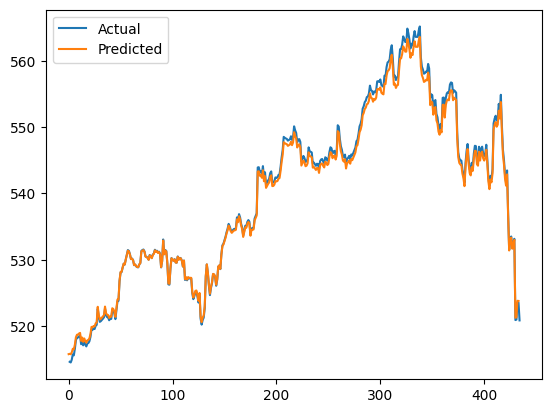

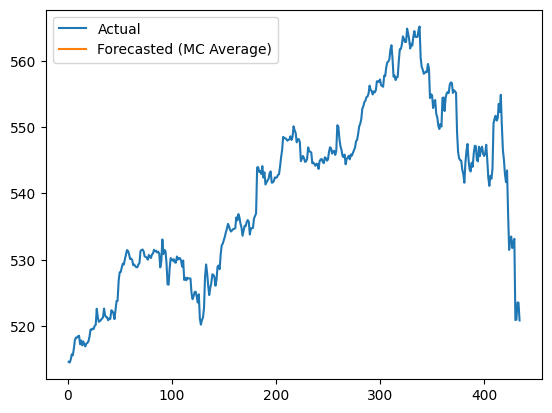

Low


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
MAE: 1.31
RMSPE: 0.38%


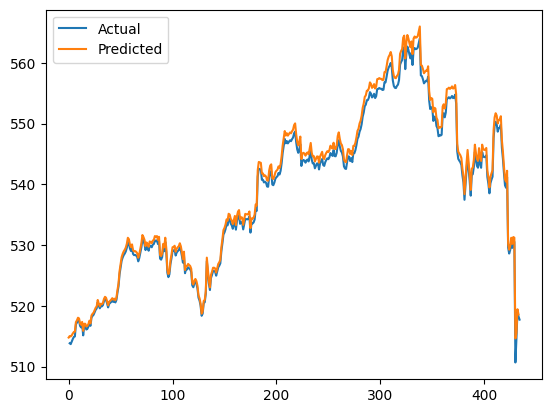

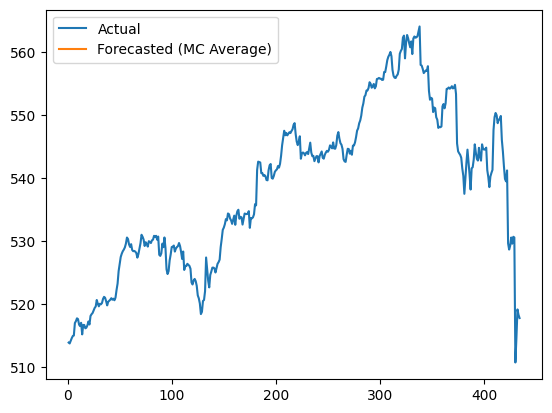

Close


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step
MAE: 1.38
RMSPE: 0.37%


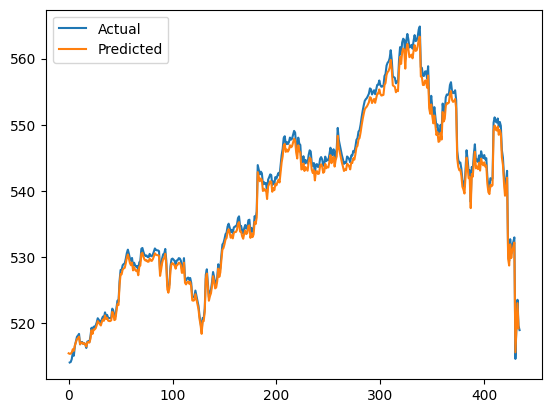

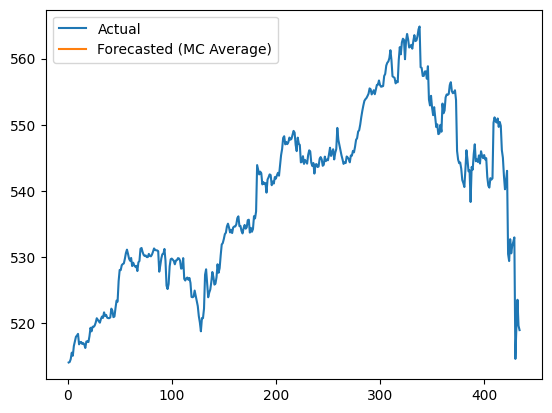

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
def sentiment_aggregate_news_forcasts():
  #news
  news_df = get_news()
  send_news(news_df)

  #sentiment
  sentiment_df =  ensemble_sentiment_analysis(news_df)
  avg_sentiment_score = average_sentiment(sentiment_df)
  print("Average Sentiment Score:", avg_sentiment_score)

  if avg_sentiment_score > 0.5:
    #forcasts
    forcasts = active_forcaster_aggregator()
    #forcasts.to_csv('forcasted_df.csv', index=False)
    return forcasts

#sentiment = sentiment_aggregate_news_forcasts()

## Repeater
(optional) If you want hourly updates on news and price forecasts (if the news is salient) this will continuously run.

[*********************100%%**********************]  1 of 1 completed

SPY
SPY
High



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step
MAE: 1.55
RMSPE: 0.37%


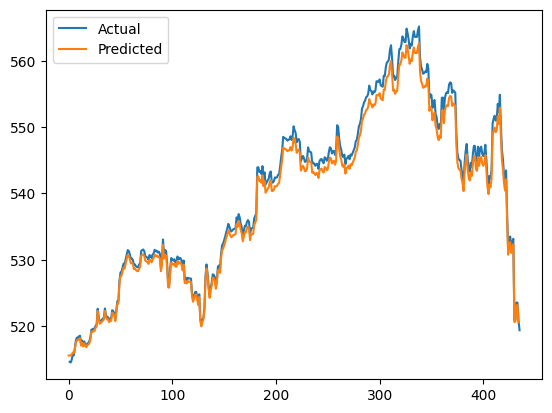

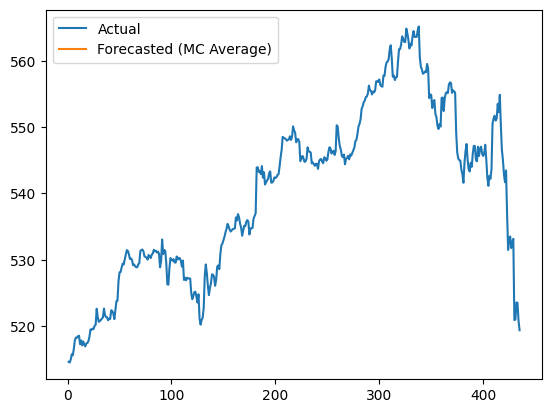

Low


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
MAE: 0.93
RMSPE: 0.31%


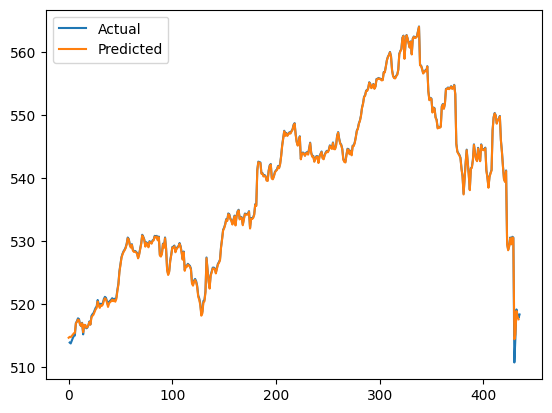

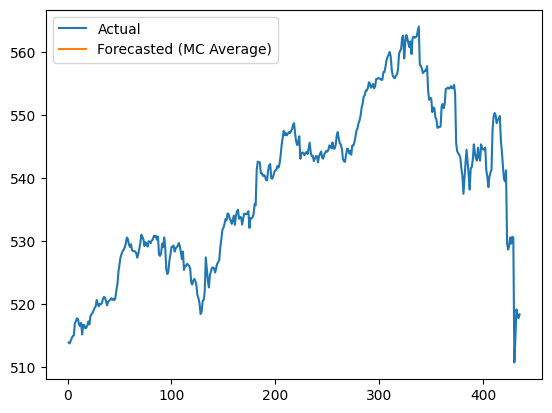

Close


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step
MAE: 1.20
RMSPE: 0.35%


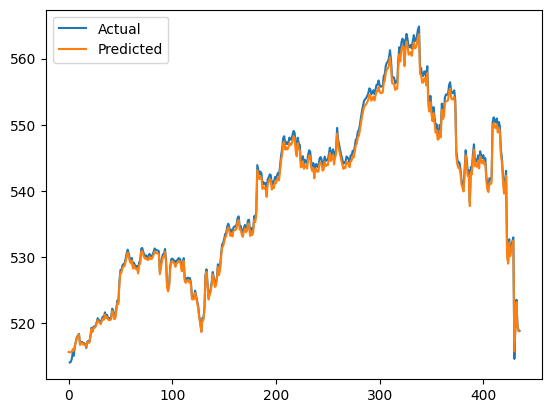

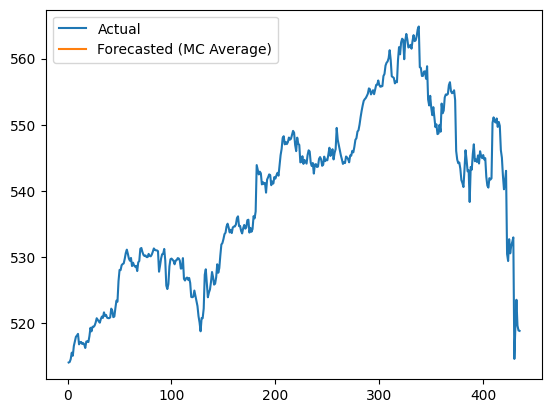

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


KeyboardInterrupt: 

In [ ]:
# Run the pipeline every specified interval
schedule.clear()
schedule.every(60).minutes.do(aggregate_news_forcasts)  # Run every 1 minute

while True:
    schedule.run_pending()
    time.sleep(1)